# Titanic Prediction Modelling and Analysis

## Importing Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Getting the Data

In [2]:
df_raw = pd.read_csv('data/train.csv', index_col = ['PassengerId'])

In [3]:
df_raw.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
779,0,3,"Kilgannon, Mr. Thomas J",male,NaN,0,0,36865,7.7375,NaN,Q
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.0,1,2,220845,65.0000,NaN,S
358,0,2,"Funk, Miss. Annie Clemmer",female,38.0,0,0,237671,13.0000,NaN,S
362,0,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,SC/PARIS 2167,27.7208,NaN,C
473,1,2,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33.0,1,2,C.A. 34651,27.7500,NaN,S
510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
423,0,3,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S


In [4]:
numerical = df_raw.select_dtypes(include = ['number', 'bool'])
categorical = df_raw.select_dtypes(exclude = ['number', 'bool'])
numerical.columns, categorical.columns

(Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object'),
 Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object'))

## Data PreProcessing

### Observing The data

In [5]:
df_raw.duplicated().sum()

0

In [6]:
df_raw.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
df_raw.shape

(891, 11)

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [9]:
df_raw.corr(numeric_only = True)['Survived'].sort_values(ascending = False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [10]:
df_raw.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

### Cleaning the Cabin column

In [11]:
# df_raw = df_raw.drop('Cabin', axis = 1)
df_raw['Cabin'].fillna('Z', inplace =True)

In [12]:
df_raw.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Z,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Z,S


In [13]:
df_raw['Cabin'].value_counts()

Cabin
Z              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

### Creating Annotations from the Name column

In [14]:
def extract_annotations(row):
    if 'Mrs' in row:
        return 'Mrs'
    elif 'Mr' in row:
        return 'Mr'
    elif 'Miss' in row:
        return 'Miss'
    elif 'Master' in row:
        return 'Master'
    else:
        return 'other'

df_raw['Annots'] = df_raw['Name'].apply(extract_annotations)

In [15]:
df_raw.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Annots
PassengerId,,,,,,,,,,,,
735,0,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,Z,S,Mr
770,0,3,"Gronnestad, Mr. Daniel Danielsen",male,32.0,0,0,8471,8.3625,Z,S,Mr
358,0,2,"Funk, Miss. Annie Clemmer",female,38.0,0,0,237671,13.0000,Z,S,Miss
191,1,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,Z,S,Mrs
13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,Z,S,Mr


### Dropping the name Column

In [16]:
df_raw.drop(['Name'], axis =1, inplace = True)

### Cleaning the Fare Column
* Removing Outliers

In [17]:
df_raw.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: xlabel='Fare'>

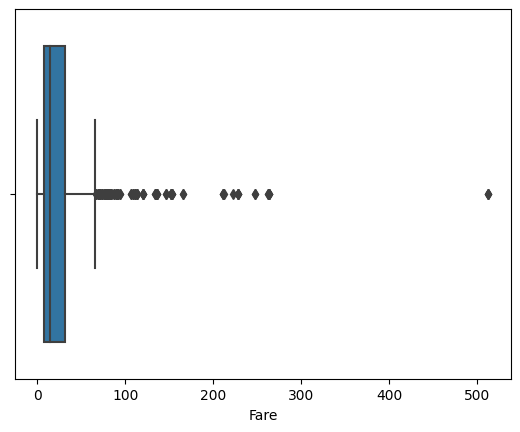

In [18]:
sns.boxplot(data = df_raw, x = 'Fare')

In [19]:
df_raw = df_raw[df_raw['Fare'] < 500]

<Axes: xlabel='Fare'>

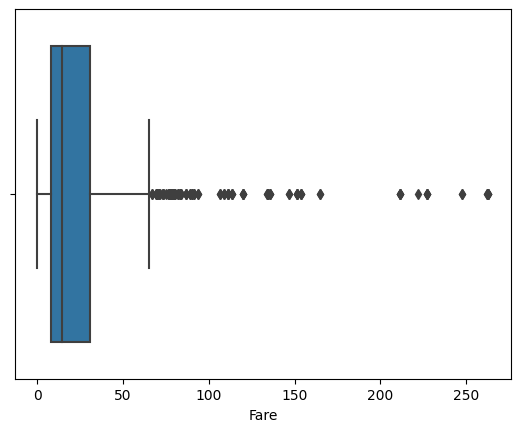

In [20]:
sns.boxplot(data = df_raw, x = 'Fare')

### Creating the FareCategory From the Fare Column --Modified

In [21]:
df_raw['FareCategory'] = pd.cut(df_raw.loc[:, 'Fare'], bins = [0, 20, 60, np.inf], labels = ['Basic', 'Medium', 'High'])

<Axes: xlabel='FareCategory'>

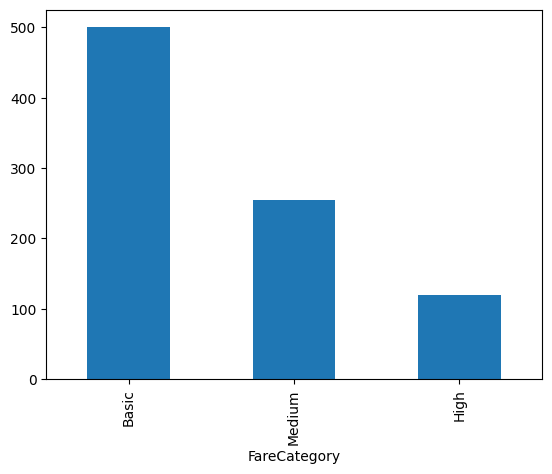

In [22]:
df_raw['FareCategory'].value_counts().plot(kind = 'bar')

In [23]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 1 to 891
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      888 non-null    int64   
 1   Pclass        888 non-null    int64   
 2   Sex           888 non-null    object  
 3   Age           711 non-null    float64 
 4   SibSp         888 non-null    int64   
 5   Parch         888 non-null    int64   
 6   Ticket        888 non-null    object  
 7   Fare          888 non-null    float64 
 8   Cabin         888 non-null    object  
 9   Embarked      886 non-null    object  
 10  Annots        888 non-null    object  
 11  FareCategory  873 non-null    category
dtypes: category(1), float64(2), int64(4), object(5)
memory usage: 84.2+ KB


In [24]:
df_raw[df_raw['FareCategory'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Annots,FareCategory
PassengerId,,,,,,,,,,,,
180,0,3,male,36.0,0,0,LINE,0.0,Z,S,Mr,NaN
264,0,1,male,40.0,0,0,112059,0.0,B94,S,Mr,NaN
272,1,3,male,25.0,0,0,LINE,0.0,Z,S,Mr,NaN
278,0,2,male,NaN,0,0,239853,0.0,Z,S,Mr,NaN
303,0,3,male,19.0,0,0,LINE,0.0,Z,S,Mr,NaN
414,0,2,male,NaN,0,0,239853,0.0,Z,S,Mr,NaN
467,0,2,male,NaN,0,0,239853,0.0,Z,S,Mr,NaN
482,0,2,male,NaN,0,0,239854,0.0,Z,S,Mr,NaN
598,0,3,male,49.0,0,0,LINE,0.0,Z,S,Mr,NaN


In [25]:
df_raw['FareCategory'] = df_raw.loc[:, 'FareCategory'].astype('category')
df_raw['FareCategory'] = df_raw.loc[:, 'FareCategory'].cat.add_categories('Free')
df_raw['FareCategory'] = df_raw.loc[:, 'FareCategory'].fillna('Free')

In [26]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 1 to 891
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      888 non-null    int64   
 1   Pclass        888 non-null    int64   
 2   Sex           888 non-null    object  
 3   Age           711 non-null    float64 
 4   SibSp         888 non-null    int64   
 5   Parch         888 non-null    int64   
 6   Ticket        888 non-null    object  
 7   Fare          888 non-null    float64 
 8   Cabin         888 non-null    object  
 9   Embarked      886 non-null    object  
 10  Annots        888 non-null    object  
 11  FareCategory  888 non-null    category
dtypes: category(1), float64(2), int64(4), object(5)
memory usage: 84.3+ KB


### Dropping the Fare Column --Modified

In [27]:
# df_raw.drop('Fare', axis = 1, inplace = True)

### Dropping the null rows in the Embarked column

In [28]:
df_raw.dropna(subset = ['Embarked'], inplace = True)

In [29]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, 1 to 891
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      886 non-null    int64   
 1   Pclass        886 non-null    int64   
 2   Sex           886 non-null    object  
 3   Age           709 non-null    float64 
 4   SibSp         886 non-null    int64   
 5   Parch         886 non-null    int64   
 6   Ticket        886 non-null    object  
 7   Fare          886 non-null    float64 
 8   Cabin         886 non-null    object  
 9   Embarked      886 non-null    object  
 10  Annots        886 non-null    object  
 11  FareCategory  886 non-null    category
dtypes: category(1), float64(2), int64(4), object(5)
memory usage: 84.1+ KB


### Cleaning the Age column

In [30]:
df_raw.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Annots,FareCategory
PassengerId,,,,,,,,,,,,
747,0,3,male,16.0,1,1,C.A. 2673,20.250,Z,S,Mr,Medium
514,1,1,female,54.0,1,0,PC 17603,59.400,Z,C,Mrs,Medium
231,1,1,female,35.0,1,0,36973,83.475,C83,S,Mrs,High
150,0,2,male,42.0,0,0,244310,13.000,Z,S,other,Basic
670,1,1,female,NaN,1,0,19996,52.000,C126,S,Mrs,Medium


In [31]:
df_raw['Age'].describe()

count    709.000000
mean      29.618011
std       14.518828
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

<Axes: >

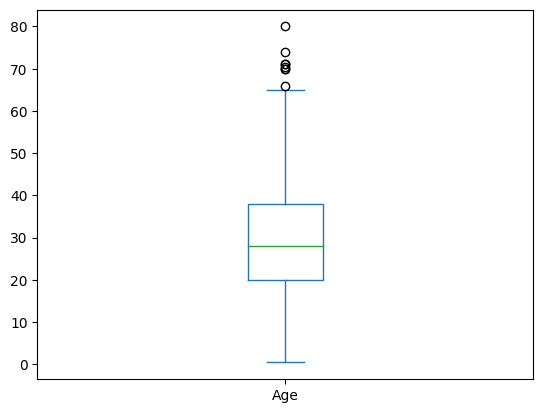

In [32]:
df_raw['Age'].plot(kind = 'box')

In [33]:
average_age = df_raw.groupby('Annots')['Age'].mean()

# Iterate over rows with null age and map the average age based on the annotation
for index, row in df_raw[df_raw['Age'].isnull()].iterrows():
    annotation = row['Annots']
    if annotation in average_age:
        df_raw.loc[index, 'Age'] = average_age[annotation]

In [34]:
average_age

Annots
Master     4.574167
Miss      21.570423
Mr        32.394207
Mrs       35.405405
other     42.652174
Name: Age, dtype: float64

In [35]:
df_raw.sample(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Annots,FareCategory
PassengerId,,,,,,,,,,,,
287,1,3,male,30.000000,0,0,345774,9.5000,Z,S,Mr,Basic
726,0,3,male,20.000000,0,0,315094,8.6625,Z,S,Mr,Basic
859,1,3,female,24.000000,0,3,2666,19.2583,Z,C,Mrs,Basic
447,1,2,female,13.000000,0,1,250644,19.5000,Z,S,Miss,Basic
240,0,2,male,33.000000,0,0,SCO/W 1585,12.2750,Z,S,Mr,Basic
341,1,2,male,2.000000,1,1,230080,26.0000,F2,S,Master,Medium
360,1,3,female,21.570423,0,0,330980,7.8792,Z,Q,Miss,Basic
269,1,1,female,58.000000,0,1,PC 17582,153.4625,C125,S,Mrs,High
804,1,3,male,0.420000,0,1,2625,8.5167,Z,C,Master,Basic


In [36]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, 1 to 891
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      886 non-null    int64   
 1   Pclass        886 non-null    int64   
 2   Sex           886 non-null    object  
 3   Age           886 non-null    float64 
 4   SibSp         886 non-null    int64   
 5   Parch         886 non-null    int64   
 6   Ticket        886 non-null    object  
 7   Fare          886 non-null    float64 
 8   Cabin         886 non-null    object  
 9   Embarked      886 non-null    object  
 10  Annots        886 non-null    object  
 11  FareCategory  886 non-null    category
dtypes: category(1), float64(2), int64(4), object(5)
memory usage: 116.4+ KB


### Creating the AgeCategory from the Age Column --modified

<Axes: >

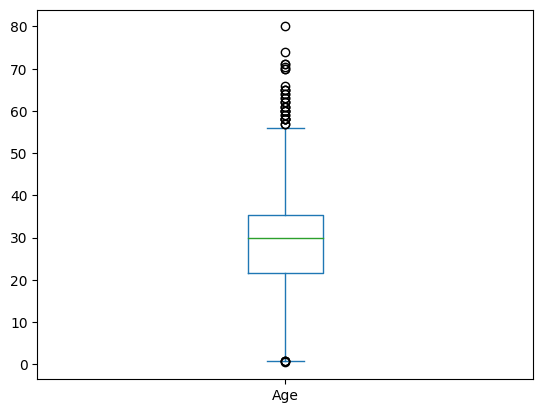

In [37]:
df_raw['Age'].plot(kind = 'box')

In [38]:
df_raw['AgeCategory'] = pd.cut(
    df_raw.loc[:, 'Age'], 
    bins = [0, 25, 50, np.inf], 
    labels = ['<25', '<50', '>50']
)

<Axes: xlabel='AgeCategory'>

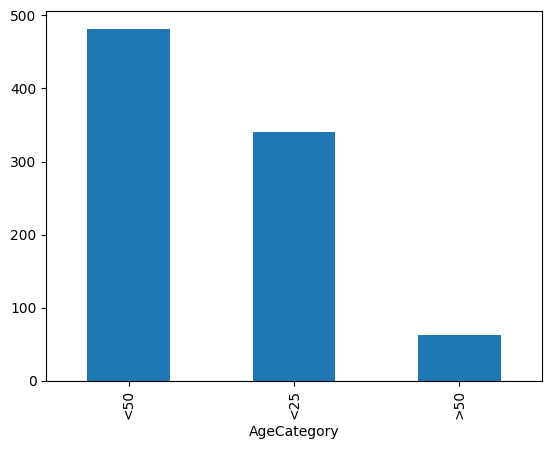

In [39]:
df_raw['AgeCategory'].value_counts().plot(kind = 'bar')

In [40]:
df_raw.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Annots,FareCategory,AgeCategory
PassengerId,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,Z,S,Mr,Basic,<25
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,High,<50
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,Z,S,Miss,Basic,<50
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,Medium,<50
5,0,3,male,35.0,0,0,373450,8.0500,Z,S,Mr,Basic,<50


In [41]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, 1 to 891
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      886 non-null    int64   
 1   Pclass        886 non-null    int64   
 2   Sex           886 non-null    object  
 3   Age           886 non-null    float64 
 4   SibSp         886 non-null    int64   
 5   Parch         886 non-null    int64   
 6   Ticket        886 non-null    object  
 7   Fare          886 non-null    float64 
 8   Cabin         886 non-null    object  
 9   Embarked      886 non-null    object  
 10  Annots        886 non-null    object  
 11  FareCategory  886 non-null    category
 12  AgeCategory   886 non-null    category
dtypes: category(2), float64(2), int64(4), object(5)
memory usage: 117.4+ KB


### Creating the HasFamilyAboard column from the Sibsp and Parch column

In [42]:
df_raw['HasFamily'] = (df_raw['SibSp'] + df_raw['Parch']) > 0
df_raw['NoOfFamily'] = (df_raw['SibSp'] + df_raw['Parch']) 

In [43]:
df_raw.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Annots,FareCategory,AgeCategory,HasFamily,NoOfFamily
PassengerId,,,,,,,,,,,,,,,
362,0,2,male,29.0,1,0,SC/PARIS 2167,27.7208,Z,C,Mr,Medium,<50,True,1
616,1,2,female,24.0,1,2,220845,65.0000,Z,S,Miss,High,<25,True,3
248,1,2,female,24.0,0,2,250649,14.5000,Z,S,Mrs,Basic,<25,True,2
317,1,2,female,24.0,1,0,244367,26.0000,Z,S,Mrs,Medium,<25,True,1
876,1,3,female,15.0,0,0,2667,7.2250,Z,C,Miss,Basic,<25,False,0


### Handling The ticket Column

In [44]:
df_raw.drop('Ticket', axis = 1, inplace = True)

### Final Cleaning and Organizing

In [45]:
one_hot = OneHotEncoder()
df_raw = pd.get_dummies(df_raw, columns = ['Sex', 'HasFamily'])
df_raw.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Annots,FareCategory,AgeCategory,NoOfFamily,Sex_female,Sex_male,HasFamily_False,HasFamily_True
PassengerId,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,Z,S,Mr,Basic,<25,1,False,True,False,True
2,1,1,38.0,1,0,71.2833,C85,C,Mrs,High,<50,1,True,False,False,True
3,1,3,26.0,0,0,7.9250,Z,S,Miss,Basic,<50,0,True,False,True,False
4,1,1,35.0,1,0,53.1000,C123,S,Mrs,Medium,<50,1,True,False,False,True
5,0,3,35.0,0,0,8.0500,Z,S,Mr,Basic,<50,0,False,True,True,False


In [46]:
ordinal = OrdinalEncoder()
ordinal_cols = ['Cabin', 'Embarked', 'Annots', 'FareCategory', 'NoOfFamily', 'AgeCategory']
cat_ordinal_changer = ordinal.fit_transform(df_raw[ordinal_cols])
df_raw[ordinal_cols] = cat_ordinal_changer
df_raw.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Annots,FareCategory,AgeCategory,NoOfFamily,Sex_female,Sex_male,HasFamily_False,HasFamily_True
PassengerId,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,145.0,2.0,2.0,0.0,0.0,1.0,False,True,False,True
2,1,1,38.0,1,0,71.2833,79.0,0.0,3.0,2.0,1.0,1.0,True,False,False,True
3,1,3,26.0,0,0,7.9250,145.0,2.0,1.0,0.0,1.0,0.0,True,False,True,False
4,1,1,35.0,1,0,53.1000,53.0,2.0,3.0,3.0,1.0,1.0,True,False,False,True
5,0,3,35.0,0,0,8.0500,145.0,2.0,2.0,0.0,1.0,0.0,False,True,True,False


In [47]:
df_raw[ordinal_cols] = df_raw[ordinal_cols].astype('int')
df_raw.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Annots,FareCategory,AgeCategory,NoOfFamily,Sex_female,Sex_male,HasFamily_False,HasFamily_True
PassengerId,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,145,2,2,0,0,1,False,True,False,True
2,1,1,38.0,1,0,71.2833,79,0,3,2,1,1,True,False,False,True
3,1,3,26.0,0,0,7.9250,145,2,1,0,1,0,True,False,True,False
4,1,1,35.0,1,0,53.1000,53,2,3,3,1,1,True,False,False,True
5,0,3,35.0,0,0,8.0500,145,2,2,0,1,0,False,True,True,False


In [48]:
df_raw.Cabin.min()

0

In [49]:
df_raw.corr()['Survived'].sort_values(ascending = False)

Survived           1.000000
Sex_female         0.544129
Fare               0.259188
FareCategory       0.209120
HasFamily_True     0.207676
Parch              0.083691
NoOfFamily         0.028986
SibSp             -0.032095
Annots            -0.058223
AgeCategory       -0.082660
Age               -0.097225
Embarked          -0.162856
HasFamily_False   -0.207676
Cabin             -0.245244
Pclass            -0.331075
Sex_male          -0.544129
Name: Survived, dtype: float64

In [50]:
df_raw.drop(['SibSp', 'Parch', 'Annots', 'NoOfFamily', 'AgeCategory', 'Age', 'Cabin', 'FareCategory'], axis = 1, inplace = True)
# df_raw.drop(['FareCategory'], axis = 1, inplace = True)

## Preparing Data for Modelling

In [51]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, 1 to 891
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         886 non-null    int64  
 1   Pclass           886 non-null    int64  
 2   Fare             886 non-null    float64
 3   Embarked         886 non-null    int64  
 4   Sex_female       886 non-null    bool   
 5   Sex_male         886 non-null    bool   
 6   HasFamily_False  886 non-null    bool   
 7   HasFamily_True   886 non-null    bool   
dtypes: bool(4), float64(1), int64(3)
memory usage: 70.4 KB


In [52]:
mm_scaler = MinMaxScaler()
fare = df_raw['Fare'].values
df_raw['Fare'] = mm_scaler.fit_transform(fare.reshape(886, 1))


In [53]:
X = df_raw.drop('Survived', axis =1).copy()
y = df_raw['Survived'].copy()

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, random_state = 42)

In [55]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((708, 7), (708,), (178, 7), (178,))

## Modelling and Error Regulator

In [56]:
logreg = LogisticRegression(max_iter = 1000, random_state = 42)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [57]:
log_reg_pred = logreg.predict(X_test)
log_acc = accuracy_score(y_test, log_reg_pred)
log_precision = precision_score(y_test, log_reg_pred),
log_recall = recall_score(y_test, log_reg_pred)
log_acc, log_precision, log_recall

(0.7584269662921348, (0.6835443037974683,), 0.75)

In [58]:
dtree = DecisionTreeClassifier(random_state = 42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [59]:
dtree_pred = dtree.predict(X_test)
d_tree_acc = accuracy_score(y_test, dtree_pred)
d_tree_precision = precision_score(y_test, dtree_pred),
d_tree_recall = recall_score(y_test, dtree_pred)
d_tree_acc, d_tree_precision, d_tree_recall

(0.7696629213483146, (0.7384615384615385,), 0.6666666666666666)

In [60]:
rforest = RandomForestClassifier(random_state = 42)
rforest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
rforest_pred = rforest.predict(X_test)
rforest_acc = accuracy_score(y_test, rforest_pred)
rforest_precision = precision_score(y_test, rforest_pred),
rforest_recall = recall_score(y_test, rforest_pred)
rforest_acc, rforest_precision, rforest_recall

(0.8089887640449438, (0.7878787878787878,), 0.7222222222222222)

In [62]:
score_df = pd.DataFrame({'log': [log_acc, log_precision[0], log_recall],
                         'dtree': [d_tree_acc, d_tree_precision[0], d_tree_recall],
                         'rforest': [rforest_acc, rforest_precision[0], rforest_recall]
                        }, index = ['Acc', 'Precision', 'Recall'])

In [63]:
score_df.T

,Acc,Precision,Recall
log,0.758427,0.683544,0.750000
dtree,0.769663,0.738462,0.666667
rforest,0.808989,0.787879,0.722222


<Axes: ylabel='Acc'>

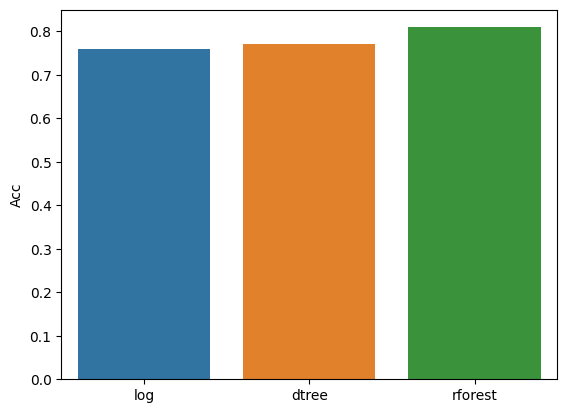

In [64]:
sns.barplot(data = score_df.T, x = score_df.T.index, y = 'Acc')

## Getting the Submission.csv ready

In [65]:
test_df = pd.read_csv('data/test.csv', index_col = ['PassengerId'])

In [83]:
test_df.info(), test_df.columns, test_df.shape[0]

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


(None,
 Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
        'Cabin', 'Embarked'],
       dtype='object'),
 418)

In [94]:
# test_df['Embarked'].values.reshape(test_df.shape[0], 1)

In [98]:
def clean_data(df):
    
    # Copy the data
    df = df.copy()
    rows = df.shape[0]
    
    # Getting the HasFamily Column
    df['HasFamily'] = (df['SibSp'] + df['Parch']) > 0
    
    # Cleaning the Name, Age, Cabin column
    df.drop(['Name', 'Age', 'Cabin', 'SibSp', 'Parch', 'Ticket'], axis = 1, inplace = True)

    # Setting one hot for the Sex and HasFamily Columns
    one_hot = OneHotEncoder()
    df = pd.get_dummies(df, columns = ['Sex', 'HasFamily'])

    # Setting up ordinal conversion for the Embarked Column
    ordinal = OrdinalEncoder()
    embarked = df['Embarked'].values
    df['Embarked'] = ordinal.fit_transform(embarked.reshape(rows, 1))
    df['Embarked'] = df['Embarked'].astype('int')

    # Cleaning the Fare Column
    mean = df['Fare'].mean()
    df['Fare'].fillna(mean, inplace = True)
    mm_scaler = MinMaxScaler()
    fare = df['Fare'].values
    df['Fare'] = mm_scaler.fit_transform(fare.reshape(rows, 1))

    return df

In [99]:
cleaned_test_df =  clean_data(test_df)

In [101]:
cleaned_test_df.isna().sum()

Pclass             0
Fare               0
Embarked           0
Sex_female         0
Sex_male           0
HasFamily_False    0
HasFamily_True     0
dtype: int64

In [102]:
test_predictions = rforest.predict(cleaned_test_df)

In [106]:
istSubmission = pd.DataFrame({'PassengerId': cleaned_test_df.index,'Survived ': test_predictions})

In [114]:
# pd.to_csv()
# istSubmission.to_csv('submissions/istSubmission')